# Healthcare on the Move: Patterns and Predictors of Medical Professional Migration in OECD Countries
**Elijah Adrian, Wuyang Ren, Pierre Lambelet, and Angelo Mladineo**

## Introduction

The Government of Canada states that health is an inalienable human right - crucial for sustainable development, economic prosperity, and poverty eradication - as well as being an indicator of a country's progress, as health increases the likelihood for sustained growth ([Global Affairs Canada](https://www.international.gc.ca/world-monde/issues_development-enjeux_developpement/global_health-sante_mondiale/health_development-sante_developpement.aspx?lang=eng), 2017). It is through healthcare systems that governments directly affect the health of a nation. Therefore, it is imperative to study healthcare systems, find patterns among their characteristics, and evaluate their performance, in order to improve wellbeing for all citizens.

The purpose of this project is to analyze patterns in the migration of healthcare workers and health outcomes. This is an important field of study because while countries are capable of training their healthcare workers domestically, a substantial number come from outside their borders and contribute significantly to the healthcare labour force and thus health outcomes.
We will focus on OECD countries specifically, as there exists comprehensive datasets on them, from which patterns of migration and healthcare systems' performance can be observed.
For example, the latest OECD annual report on migration mentions that migration into OECD countries, in addition to employment of foreigners within them, reached record high levels in 2022 ([OECD](https://www.oecd.org/migration/international-migration-outlook-1999124x.htm), 2023). 

In order to explore the impact of medical professionals backgrounds', this research project is divided into three research sections of interest, with an additional section focused on maps showcasing the migration of medical professionals geographically:

- The relationship between health outcomes and migration of healthcare providers 
- Government health insurance, per capita healthcare spending, and remuneration of medical professionals as predictive factors of healthcare professional migration
- Relationship between domestic and foreign-trained medical professionals
- Maps

## Data

### Importing libraries

As was mentioned in the introduction, the datasets in this project come from datasets found in [OECD data](https://data.oecd.org), but before we present and clean them, we start by importing the Python libraries that allow us to work with the data.

These are:
`math`, `pandas`, `numpy`, `matplotlib.pyplot`, `seaborn`, and `statsmodels.api`.

We also have to load all the libraries necessary for the interactive map, most of these stem from `bokeh`, in addition to `geopandas` and `json`.

In [1]:
#! pip install geopandas

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import geopandas as gpd
from bokeh.io import output_notebook,show
from bokeh.plotting import figure, ColumnDataSource
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, HoverTool, Label, Legend
from bokeh.palettes import brewer
output_notebook()
import json
from bokeh.palettes import OrRd

%matplotlib inline
sns.set()

Loading BokehJS ...

### Loading datasets

Now we read all the data files from the OECD. The naming convention we use is an abbreviation of the datasets' names (for example `demo_ref_raw` stands for **demo**graphic **ref**erence data and so on) and all of them have the suffix "raw" in their variable name to indicate that the datasets have not been processed.



In [2]:
demo_ref_raw = pd.read_csv('demographicref.csv') #demographic reference data
econ_ref_raw = pd.read_csv('econref.csv') #economic reference data
health_expen_raw = pd.read_csv('healthexpenditure.csv') #healthcare expenditure data
health_qual_raw = pd.read_csv('healthquality.csv') #healthcare quality data
health_resor_raw = pd.read_csv('healthresources.csv') #healthcare resources data
health_util_raw = pd.read_csv('healthutil.csv') #healthcare utilization data
social_proc_raw = pd.read_csv('socialprotection.csv') #social healthcare protection data
worker_migr_raw = pd.read_csv('healthworkmigration.csv') #healthcare worker migration data
health_stat_raw = pd.read_csv('healthstatus.csv',nrows = 284583) #health status data

Note that the final dataset (*healthstatus.csv*) cannot be loaded past the 284,614th line, so in order to avoid having partial data on one variable we needed to cut approximately the last 40,000 entries.

Each dataset we include was obtained from the following sources:
- [Demographic Reference Data](https://stats.oecd.org/Index.aspx?DataSetCode=HEALTH_DEMR)  
- [Economic Reference Data](https://stats.oecd.org/Index.aspx?DataSetCode=HEALTH_ECOR)  
- [Healthcare Expenditure Data](https://stats.oecd.org/Index.aspx?DataSetCode=SHA) 
- [Healthcare Quality Data](https://stats.oecd.org/Index.aspx?DataSetCode=HEALTH_HCQI)  
- [Healthcare Resources Data](https://stats.oecd.org/Index.aspx?DataSetCode=HEALTH_REAC)  
- [Healthcare Utilization Data](https://stats.oecd.org/Index.aspx?DataSetCode=HEALTH_PROC)  
- [Social Healthcare Protection Data](https://stats.oecd.org/Index.aspx?DataSetCode=HEALTH_PROT)  
- [Healthcare Worker Migration Data](https://stats.oecd.org/Index.aspx?DataSetCode=HEALTH_WFMI)  

Full citations are at the end of the document.

### Data cleaning

We start the data cleaning process by removing unwanted columns of data. We are left with columns that we deemed relevant for our project.

In [3]:
demo_ref_col = demo_ref_raw[['Variable','Measure','Country','Year','Value']]
econ_ref_col = econ_ref_raw[['Variable', 'Measure', 'Country','Year', 'Value']]
health_expen_col = health_expen_raw[['Financing scheme', 'Function','Provider', 'Measure', 'Country', 'Year', 'Unit', 'Value']]
health_qual_col = health_qual_raw[['Country','Periods','Indicator','Gender','Age Group','Value','Value.1']]
health_resor_col = health_resor_raw[['Variable','Measure','Country','Year','Value']]
health_util_col = health_util_raw[['Variable','Measure','Country','Year','Value']]
social_proc_col = social_proc_raw[['Variable','Measure','Country','Year','Value']]
worker_migr_col = worker_migr_raw[['Country','Variable','Country of origin','Year','Value']]
health_stat_col = health_stat_raw[['Variable','Measure','Country','Year','Value']]

We proceed to remove unwanted rows of data. Typically, these are rows containing data measured in units that cannot be compared between countries (e.g. in local currency or raw numbers of incidents). In addition to that, we have to remove rows containing variables with few observations or rows that are unlikely to be helpful for our purposes. Almost all data sets required this, the exceptions are `demo_ref_col` and `worker_mig_col`.

In [4]:
econ_ref_clean = econ_ref_col.loc[(econ_ref_col['Measure']=='National currency unit per US$, PPP')|
                       (econ_ref_col['Measure']=='/capita, US$ purchasing power parity')|
                       (econ_ref_col['Measure']=='Million US$ at exchange rate')|
                       (econ_ref_col['Measure']=='/capita, US$ exchange rate ')|
                       (econ_ref_col['Measure']=='/capita, US$ purchasing power parity')]

health_expen_clean = health_expen_col.loc[(health_expen_col['Measure']=='Share of gross domestic product')|
                       (health_expen_col['Measure']=='Constant prices, OECD base year')|
                       (health_expen_col['Measure']=='Share of current expenditure on health')|
                       (health_expen_col['Measure']=='Per capita, current prices, current PPPs')]

health_qual_clean = health_qual_col.loc[((health_qual_col['Value']=='Age-sex standardised rate per 100 000 population')|
               (health_qual_col['Value']=='Age-sex standardised rate per 100 patients')|
               (health_qual_col['Value']=='Age-standardised survival (%)'))|
               (health_qual_col['Value']=='Rate per 100 deaths (%)')|
               (health_qual_col['Value']=='Crude rate per 100 patients')|
               (health_qual_col['Value']=='Age-sex standardised ratio')|
               (health_qual_col['Value']=='Age-standardised survival (%)')|
               (health_qual_col['Value']=='Ratio')|
               (health_qual_col['Gender']=='Total')] 

health_qual_clean = health_qual_clean.drop(list((health_qual_clean.loc[(health_qual_clean['Periods']=="2000-2004")|
                                                                      (health_qual_clean['Periods']=="2005-2009")|
                                                                      (health_qual_clean['Periods']=="2010-2014")|
                                                                      (health_qual_clean['Periods']=="2015-2019")]).index.values)) 

health_resor_clean = health_resor_col.loc[(health_resor_col['Measure']=='Density per 1 000 population (head counts)')|
                (health_resor_col['Measure']=='Per million population')|
                (health_resor_col['Measure']=='% of total physicians (head counts)')|
                (health_resor_col['Measure']=='Per 1 000 population')|
                (health_resor_col['Measure']=='% of physicians (head counts)')|
                (health_resor_col['Measure']=='Per 100 000 population')|
                (health_resor_col['Measure']=='% of total hospital employment (head counts)')|
                (health_resor_col['Measure']=='Per 1 000 live births')|
                (health_resor_col['Measure']=='Salaried, income, PPP for private consumption, in US$')] 

health_util_clean = health_util_col.loc[(health_util_col['Measure']=='Per 100 000 population')|
               (health_util_col['Measure']=='% performed as inpatient cases')|
               (health_util_col['Measure']=='% performed as day cases')|
               (health_util_col['Measure']=='Per 100 000 females')|
               (health_util_col['Measure']=='Inpatient cases per 100 000 population ')|
               (health_util_col['Measure']=='Total procedures per 100 000 population')|
               (health_util_col['Measure']=='Day cases per 100 000 population')|
               (health_util_col['Measure']=='Per 1 000 population')|
               (health_util_col['Measure']=='% of children immunised')|
               (health_util_col['Measure']=='Waiting times from specialist assessment to treatment: Mean (days)')|
               (health_util_col['Measure']=='Waiting times of patients on the list: % of all patients waiting more than 3 months')|
               (health_util_col['Measure']=='Waiting times of patients on the list: Mean (days)')]

social_proc_clean = social_proc_col.loc[(social_proc_col['Measure']=='% of total population')|
                                        (social_proc_col['Measure']=='% of total population covered')] 

health_stat_clean = health_stat_col.loc[(health_stat_col['Measure']=='Deaths per 100 000 females (standardised rates)')|
               (health_stat_col['Measure']=='Deaths per 100 000 females (crude rates)')|
               (health_stat_col['Measure']=='Years lost, /100 000 females, aged 75 years old')|
               (health_stat_col['Measure']=='Deaths per 100 000 males (standardised rates)')|
               (health_stat_col['Measure']=='Deaths per 100 000 population (standardised rates)')|
               (health_stat_col['Measure']=='Deaths per 100 000 males (crude rates)')|
               (health_stat_col['Measure']=='Years lost, /100 000 males, aged 75 years old')|
               (health_stat_col['Measure']=='Years lost, /100 000 population, aged 75 years old')|
               (health_stat_col['Measure']=='Deaths per 100 000 population (crude rates)')|
               (health_stat_col['Measure']=='% of population (crude rate)')|
               (health_stat_col['Measure']=='Years')|
               (health_stat_col['Measure']=='Incidence per 100 000 population')|
               (health_stat_col['Measure']=='Deaths per 1 000 live births')]

Next we want to remove all the countries not present in the migration dataframe (`worker_migr_col`) from every other dataframe. We specifically select countries with a sufficient number of observations (50 observations was deemed appropriate). To do this we use a for loop that appends an empty list with countries if they have sufficient migration data and are not in the list already (to avoid for repeated entries). 

This results in the `migr_list` list, where we have all the countries (i.e. country names) that meet our observations criteria without duplicates.

In [5]:
migr_list = []
for country in worker_migr_col["Country"]:
    if (worker_migr_col["Country"].value_counts()[country] > 50) and (country not in migr_list):
        migr_list.append(country)

We put `migr_list` into action immediately by filtering for all the rows in each dataframe where the *"Country"* column's value is in the list.

In [6]:
econ_ref_clean = econ_ref_clean.loc[(econ_ref_clean["Country"].isin(migr_list))]
demo_ref_clean = demo_ref_col.loc[(demo_ref_col["Country"].isin(migr_list))]
health_expen_clean = health_expen_clean.loc[(health_expen_clean["Country"].isin(migr_list))]
health_qual_clean = health_qual_clean.loc[(health_qual_clean["Country"].isin(migr_list))]
health_resor_clean = health_resor_clean.loc[(health_resor_clean["Country"].isin(migr_list))]
health_util_clean = health_util_clean.loc[(health_util_clean["Country"].isin(migr_list))]
social_proc_clean = social_proc_clean.loc[(social_proc_clean["Country"].isin(migr_list))]
health_stat_clean = health_stat_clean.loc[(health_stat_clean["Country"].isin(migr_list))]

Lastly before pivoting we want to reset all the indexes.

In [7]:
econ_ref_clean = econ_ref_clean.reset_index()
demo_ref_clean = demo_ref_clean.reset_index()
health_expen_clean = health_expen_clean.reset_index()
health_qual_clean = health_qual_clean.reset_index()
health_resor_clean = health_resor_clean.reset_index()
health_util_clean = health_util_clean.reset_index()
social_proc_clean = social_proc_clean.reset_index()
health_stat_clean = health_stat_clean.reset_index()

It is important to note that the dataframes in the code cell above have the suffix *"clean"*, this is to indicate that they have been processed (i.e. cleaned) and are ready for statistical analysis. We started using this naming convention before, and while these versions of the dataframes are not the ones we would present (a more suitable display is in the next code cell), it is from these versions where most of our work will stem. 

Next we have to pivot each dataframe, and merge the reference data, i.e. data that is not directly related to healthcare but that describes the countries we are going to use (such as purchasing power for `econ_ref` and employment for `demo_ref`).

In [8]:
worker_migr = worker_migr_col.pivot_table(index = ['Year','Country'], columns = ['Variable'], values = 'Value')
demo_ref = demo_ref_clean.pivot_table(index = ['Year','Country'], columns = ['Measure','Variable'], values = 'Value')
econ_ref = econ_ref_clean.pivot_table(index = ['Year','Country'], columns = ['Measure','Variable'], values = 'Value')
health_expen = health_expen_clean.pivot_table(index = ['Year','Country'], columns = ['Measure','Function'], values = 'Value')
health_qual = health_qual_clean.pivot_table(index = ['Periods','Country','Age Group'], columns = ['Value','Indicator'], values = 'Value.1')
health_resor = health_resor_clean.pivot_table(index = ['Year','Country'], columns = ['Measure','Variable'], values = 'Value')
health_util = health_util_clean.pivot_table(index = ['Year','Country'], columns = ['Measure','Variable'], values = 'Value')
social_proc = social_proc_clean.pivot_table(index = ['Year','Country'], columns = ['Measure','Variable'], values = 'Value')
health_stat = health_stat_clean.pivot_table(index = ['Year','Country'], columns = ['Measure','Variable'], values = 'Value')

reference = pd.merge(demo_ref,econ_ref, on = ['Year','Country'])

In [9]:
worker_migr.head(10) # our primary data frame of interest

Variable         % of foreign-trained doctors  % of foreign-trained nurses  \
Year Country                                                                 
2010 Austria                            3.900                          NaN   
     Belgium                            8.200                        1.460   
     Canada                            23.197                        7.220   
     Costa Rica                           NaN                          NaN   
     Czechia                            4.400                          NaN   
     Denmark                            8.750                        2.000   
     Estonia                            1.420                        0.030   
     Finland                           10.460                        0.810   
     France                             7.451                        2.473   
     Germany                            6.565                          NaN   

Variable         Domestically-trained doctors  Domestically-trained nurses  \
Year Country                                                                 
2010 Austria                          31753.0                          NaN   
     Belgium                          49038.0                     163140.0   
     Canada                           62059.0                     327399.0   
     Costa Rica                           NaN                          NaN   
     Czechia                          40740.0                          NaN   
     Denmark                          18821.0                      53388.0   
     Estonia                           5682.0                      11265.0   
     Finland                          15259.0                      97019.0   
     France                          197234.0                     511340.0   
     Germany                              NaN                          NaN   

Variable         Foreign-trained doctors - Annual inflow  \
Year Country                                               
2010 Austria                                       191.0   
     Belgium                                       504.0   
     Canada                                       2437.0   
     Costa Rica                                     15.0   
     Czechia                                       103.0   
     Denmark                                       296.0   
     Estonia                                        11.0   
     Finland                                       226.0   
     France                                          NaN   
     Germany                                      1426.0   

Variable         Foreign-trained doctors - Stock  \
Year Country                                       
2010 Austria                              1289.0   
     Belgium                              4380.0   
     Canada                              18765.0   
     Costa Rica                              NaN   
     Czechia                              1874.0   
     Denmark                              1809.0   
     Estonia                                82.0   
     Finland                              2123.0   
     France                              15903.0   
     Germany                             20029.0   

Variable         Foreign-trained nurses - Annual inflow  \
Year Country                                              
2010 Austria                                        NaN   
     Belgium                                      361.0   
     Canada                                      2333.0   
     Costa Rica                                     6.0   
     Czechia                                        NaN   
     Denmark                                      162.0   
     Estonia                                        2.0   
     Finland                                      155.0   
     France                                       442.0   
     Germany                                        NaN   

Variable         Foreign-trained nurses - Stock  Total number of doctor

Here we have the final versions of our dataframes. We have seven dataframes that display data regarding healthcare (`worker_migr` has information about healthcare workers too), and one dataframe (the `reference` dataframe) that describes countries' economic and demographic conditions.

Most dataframes have the same hierarchical index, where we have 'Year' and 'Country' as the two indices. `health_qual` is the exception, as it uses three indices, but all dataframes follow an initial index regarding time measurements, followed by a location ("Country") index.

## Healthcare Quality and Health Status as Predictive Factors of Healthcare Professional Migration
 

### Measuring Healthcare Quality and Health Status

We hypothesize that countries with poorer healthcare outcomes and health status tend to have a higher number of immigrant healthcare professionals. The rationale is the assumption that governments of these nations might be incentivized to bolster healthcare capabilities by facilitating the immigration of healthcare workers to improve overall health metrics.

Our project evaluates healthcare quality and health status from three distinct perspectives:

1. **Quality of Acute Care**: We assess this through the mortality rates and hospital readmission rates for critical conditions, including:
* Acute Myocardial Infarction (AMI, commonly known as a heart attack)
* Haemorrhagic stroke
* Ischemic stroke
* Hip fractures with surgeries initiated within two calendar days of hospital admission.
2. **Patient Experience:** This aspect is gauged through responses to questionnaires, focusing on the percentage of patient having enough consultation time
3. **Perceived Health Status**: We measure this through the percentage of the population that perceives their health as poor.
4. **Age Demographics**: Specifically, the percentage of the population over 65, as this demographic typically requires more healthcare services, impacting overall health service demand.

Through these measures, we aim to investigate how healthcare quality and health status could predict the migration of healthcare professionals.

In [10]:
mor_val =  health_qual_clean["Value"] == "Age-sex standardised rate per 100 patients"
hos_val =  health_qual_clean["Value"] == "Age-sex standardised rate per 100 000 population" #Measure of mortality rate and hospital admission/readmission rate
doc_val = health_qual_clean["Value"] == "Crude rate per 100 patients"
doc_gender = health_qual_clean["Gender"] == "Total"

health_qual_clean['Periods'] = pd.to_numeric(health_qual_clean['Periods'])
yrs =  health_qual_clean["Periods"] > 2014

mor_ind = health_qual_clean["Indicator"].str.contains("mortality")
re_hos_ind = health_qual_clean["Indicator"].str.contains("hospital readmission")
doc_val_ind = health_qual_clean["Indicator"].str.contains("spending enough time with patients during the consultation")

qual_mor = health_qual_clean[mor_ind & yrs & mor_val]
qual_re_hos = health_qual_clean[re_hos_ind & yrs & hos_val]
qual_doc= health_qual_clean[doc_val_ind & yrs & doc_val & doc_gender ]


mor_countries = set(qual_mor['Country'].unique())
re_hos_countries = set(qual_re_hos['Country'].unique())
doc_countries = set(qual_doc['Country'].unique())

common_countries = mor_countries & re_hos_countries & doc_countries #filtering out countries

qual_mor_filtered = qual_mor[qual_mor['Country'].isin(common_countries)]
qual_re_hos_filtered = qual_re_hos[qual_re_hos['Country'].isin(common_countries)]
qual_doc_filtered = qual_doc[qual_doc['Country'].isin(common_countries)]

It is important to note that we create a variable called `common_countries` that will serve as a filter, such that we can check if the countries we want to observe have all the available data for the metrics we want to use.

With our filtered data, we create new, small "summary" dataframes that allow for a clear plotting of average mortality and average hospital readmission rates since the year 2015.

In [11]:
summary_qual_mor = pd.DataFrame(qual_mor_filtered.groupby(['Country'])['Value.1'].mean()).rename(columns={'Value.1': 'Mortality'})
summary_qual_re_hos = pd.DataFrame(qual_re_hos_filtered .groupby(['Country'])['Value.1'].mean()).rename(columns={'Value.1': 'Hospital Readmission'})
summary_qual_doc =  pd.DataFrame(qual_doc_filtered.groupby(['Country'])['Value.1'].mean()).rename(columns={'Value.1': 'Enough Consultation Time'})

We do the same to represent countries with "bad health", using the crude rate as a first filter (in this context, crude rate is a measurement of health quality spanning from "very good" to "very bad"), and then filtering specifically for "bad/very bad health" such that we can focus on the proportion of people that are perceived to have bad health conditions. 

In [12]:
bad_health = pd.DataFrame(health_stat["% of population (crude rate)"]["Bad/very bad health, total aged 15+"]).rename(columns={'Bad/very bad health, total aged 15+': 'Bad Health'})
bad_health = bad_health[bad_health.index.get_level_values('Year') > 2014]
bad_health_filterd = bad_health[bad_health.index.get_level_values('Country').isin(common_countries)]

summary_bad_health = pd.DataFrame(bad_health_filterd.groupby(['Country'])['Bad Health'].mean()) 

We also need to consider the population age distribution of countries as it may be a factor that influences the perceived health of the nation, and in turn how effective each healthcare system is. 

In [13]:
age_ref = pd.DataFrame(reference["% of total population"]["Population: 65 years old and over"])
age_ref = age_ref[age_ref.index.get_level_values('Year') > 2014]
age_ref_filtered = age_ref[age_ref.index.get_level_values('Country').isin(common_countries)]

age_summary = pd.DataFrame(age_ref_filtered.groupby("Country").mean())

To account for the age distribution, the process is similar to `summary_bad_health`, where we first extract values from the `reference`, specifically, the *"Population: 65 years old and over"* column that is within the *"% of total population"* column set. Second, as 2015- 2022 is the time period with the most available data for our variables of interest, we filter for all values starting in 2015 and index them by year. Third, we create a list of countries with available data for all variables (`common_countries`) and filter for countries that are in the list. Finally, we create a plot-friendly data frame called `age_summary` where we take the mean of each of the countries' entries to have an average percentage of the population that is 65 years old and over.


We proceed to plot mortality rates, hospital readmission rates, percentages of the population with bad health conditions and percentage of patients with enough consultation time among our common countries.

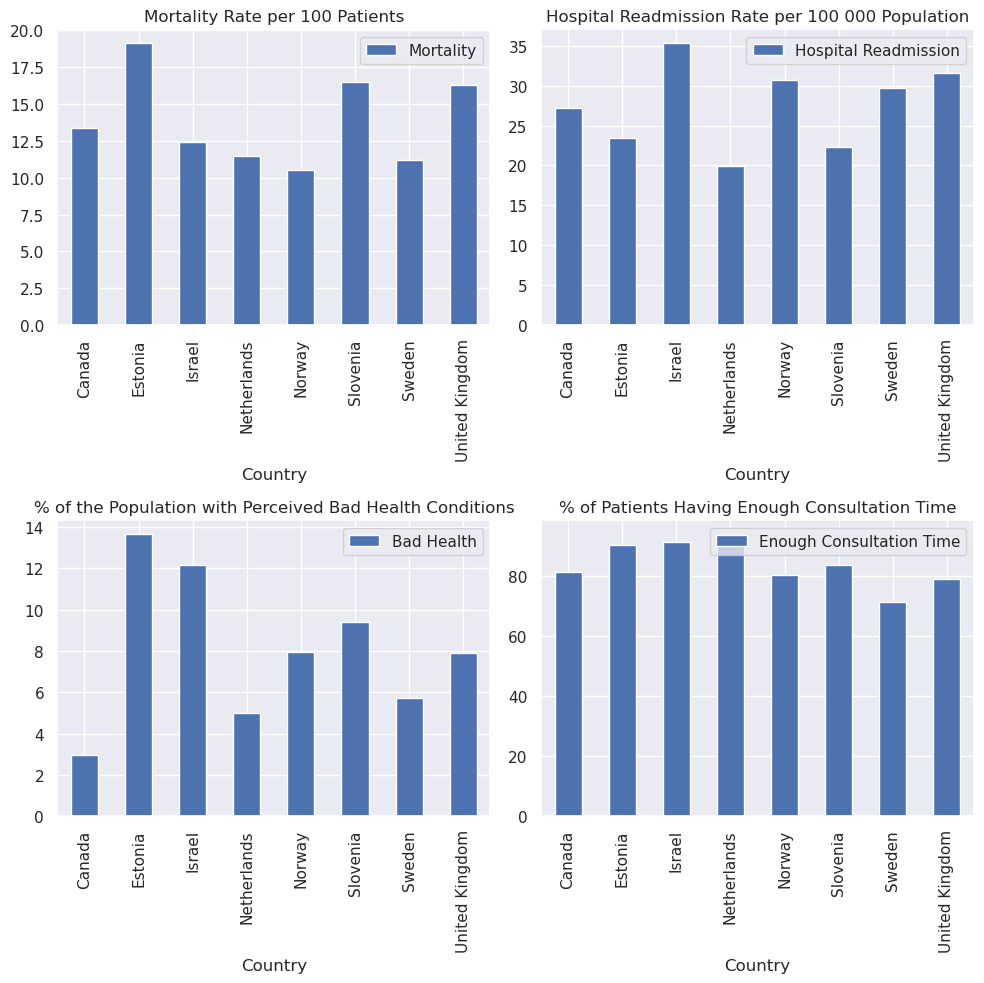

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0] = summary_qual_mor.plot.bar(ax=ax[0,0])
ax[0, 0].set_title("Mortality Rate per 100 Patients")
ax[0, 1] = summary_qual_re_hos.plot.bar(ax=ax[0, 1])
ax[0, 1].set_title("Hospital Readmission Rate per 100 000 Population")
ax[1, 0] = summary_bad_health.plot.bar(ax=ax[1,0])
ax[1, 0].set_title("% of the Population with Perceived Bad Health Conditions")
ax[1, 1] = summary_qual_doc.plot.bar(ax = ax[1,1])
ax[1, 1].set_title("% of Patients Having Enough Consultation Time")
plt.tight_layout()

From the graphs we can start visualizing the distinction between health quality and patient satisfaction, as mortality rates and hospital readmission rates inform us about the former, while the perceived population health and the percentage of patients with enough consultation time tell us about the latter. 

The most notable points for each are as follows:
- Mortality rates:
    - Highest: Estonia, with 19.11 per 100 patients
    - Lowest: Norway, with 10.55 per 100 patients
    - Mean: 13.85 per 100 patients
- Hospital readmission rates:
    - Highest: Israel, with 35.30 per 100,000 population
    - Lowest: Netherlands, with 19.88 per 100,000 population
    - Mean: 27.53 per 100,000 population
- Population percentage with bad health:
    - Highest: Estonia, with 13.65%
    - Lowest: Canada, with 2.96%
    - Mean: 8.09%
- Percentage of patients with enough consultation time:
    - Highest: Netherlands, with 93.74%
    - Lowest: Sweden, with 71.35%
    - Mean: 83.74%
    
More importantly, at this point we have different measures for health systems effectiveness across different countries through different metrics, thus, we can start look for the relationship proportions of foreign workers might have with the metrics we plotted.

### Predicting Healthcare Professionals Migration

Similarly to how we filtered out health quality statistics, we now refer to the `worker_migr` data frame so that we can access the average foreign-trained doctors inflow per year since 2015 and for our countries of interest (located in `common_countries`). In addition to factors in healthcare quality and health status, we expect foreign-trained doctors inflow to be dependent on the number of domestically-trained doctors as well, as it reflects the size of a healthcare system, and having a larger system may require doctors, hence, more immigrant doctors.

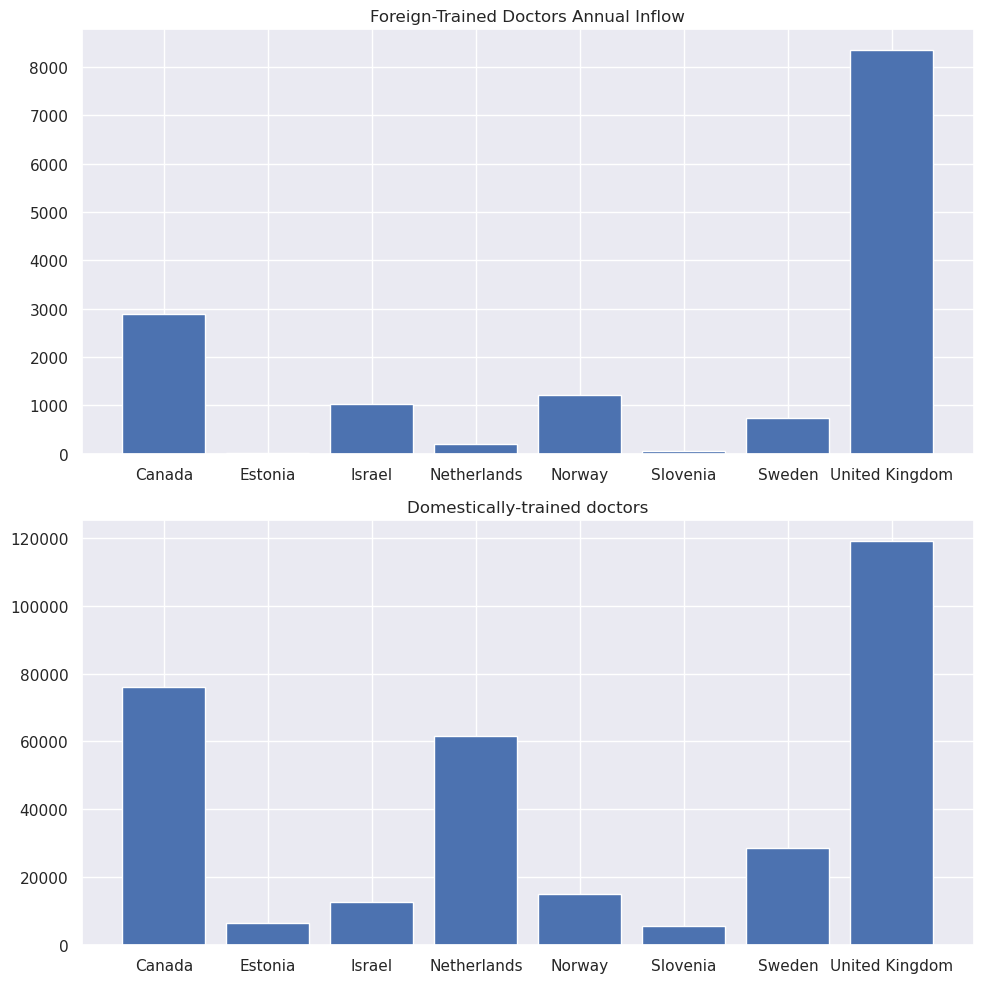

In [15]:
worker_migr_filtered = worker_migr[["Foreign-trained doctors - Annual inflow", "Domestically-trained doctors"]][worker_migr.index.get_level_values('Year') > 2014]
worker_migr_summary = worker_migr_filtered.groupby(['Country'])[['Foreign-trained doctors - Annual inflow', "Domestically-trained doctors"]].mean().fillna(0)
worker_migr_summary = worker_migr_summary[worker_migr_summary.index.get_level_values('Country').isin(common_countries)]
fig, ax = plt.subplots(2, 1, figsize = (10,10))
ax[0].bar(worker_migr_summary.index, worker_migr_summary['Foreign-trained doctors - Annual inflow'])
ax[1].bar(worker_migr_summary.index, worker_migr_summary['Domestically-trained doctors'])
ax[0].set_title("Foreign-Trained Doctors Annual Inflow")
ax[1].set_title("Domestically-trained doctors")
plt.tight_layout()

From the two graphs, we observe the average yearly inflow of doctors for each country, where the United Kingdom outpaces every other country by a large margin. For most countries, seeing a greater inflow of foreign-trained doctors coincides with a larger number of domestically trained doctors. The Netherlands, however, has a large number of domestic doctors while having a relative low inflow of foreign-trained doctors. Given this result, to better understand the predictive power of our variables of interest (healthcare quality and health status) we will compare the performance of our model with and without including number of domestically-trained doctors. 

We continue filtering the reference data frame so that we can form a dataframe called `imm_qual`, where we include all the characteristics from our countries of interest, and these are merged with the average inflow of foreign doctors, such that we can investigate whether there is a relationship among the data.

In [16]:
imm_qual = pd.merge(summary_qual_mor, summary_qual_re_hos, on = ['Country'])
imm_qual = pd.merge(imm_qual, summary_qual_doc, on = ['Country'])
imm_qual = pd.merge(imm_qual, summary_bad_health, on = ['Country'])
imm_qual = pd.merge(imm_qual, worker_migr_summary, on = ['Country']) 
imm_qual = pd.merge(imm_qual, age_summary, on = ['Country']) 

We utilize our new data frame to plot a correlation matrix to explore links between these characteristics 




In [17]:
imm_correlation_matrix = imm_qual.corr()

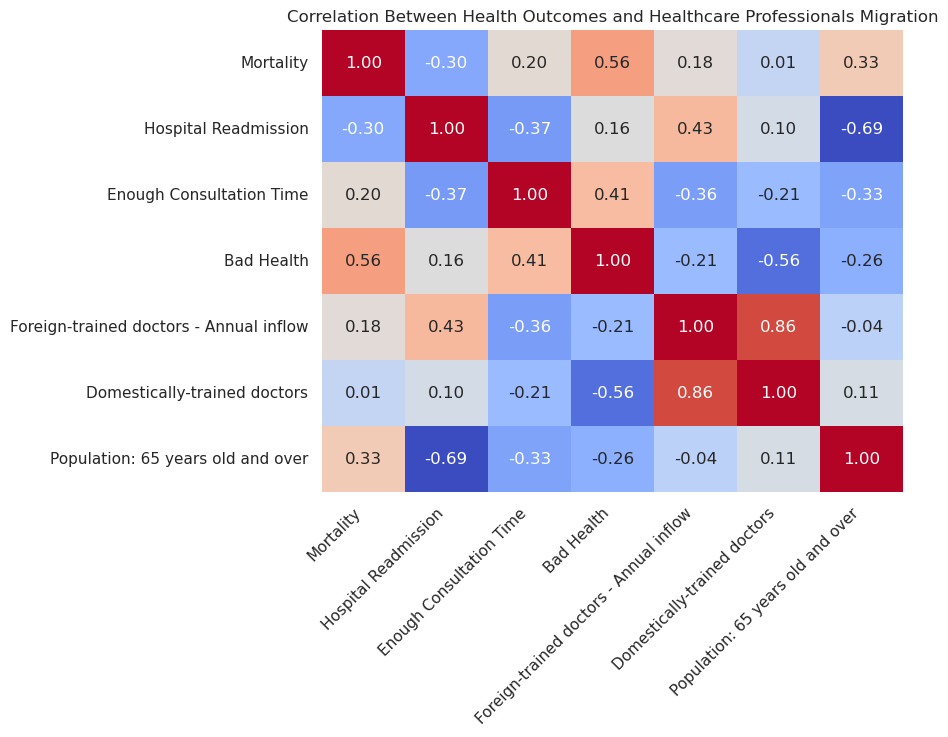

In [18]:
plt.figure(figsize=(7.5, 6))  
sns.heatmap(imm_correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=False)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Correlation Between Health Outcomes and Healthcare Professionals Migration')

plt.show()

Emphasizing on the "Foreign-trained doctors - Annual inflow" variable, there is a slight, positive correlation among mortality rates and flow of foreign doctors (with a correlation coefficient, $r$, of $0.18$), meanwhile there is a considerably higher positive correlation between hospital readmission rates and foreign- trained doctors annual inflow ($r = 0.43$). Similarly, we also observe a negative correlation when it comes to the percentage of patients having enough consultation time ($r= -0.36$). This implies that lower quality of both acute and general healthcare predicts a higher number of foreign-trained doctors annual inflow, which is consistent with our hypothesis. 

Contrary to our hypothesis, there is a negative correlation of $-0.21$ between the percentage of the population having perceived bad health and foreign-trained doctors inflow. In addition, percentage of 65 years old and over population also demonstrates a week, negative correlation with doctors inflow.

Given these results, we will then construct regression models better understand the predictive power of these variables.

## Linear Regression Model 1: Healthcare Quality and Health Status

To check if the correlations found above indicate good predictors for foreign doctors in healthcare quality, we used an OLS regression, where we regress Foreign-trained doctors inflow on Mortality rates, Hospital Readmission rates, Sufficient Consultation Time percentage, and Perceived Bad Health percentage.

In [19]:
from sklearn import linear_model

X = imm_qual[["Mortality", "Enough Consultation Time", "Bad Health", "Hospital Readmission", "Population: 65 years old and over"]]
y = imm_qual['Foreign-trained doctors - Annual inflow'] 

X = sm.add_constant(X)
doc_imm_model = sm.OLS(y, X)
doc_imm_result = doc_imm_model.fit()

print(doc_imm_result.summary())

                                       OLS Regression Results                                      
Dep. Variable:     Foreign-trained doctors - Annual inflow   R-squared:                       0.872
Model:                                                 OLS   Adj. R-squared:                  0.551
Method:                                      Least Squares   F-statistic:                     2.715
Date:                                     Tue, 23 Apr 2024   Prob (F-statistic):              0.291
Time:                                             00:06:16   Log-Likelihood:                -66.117
No. Observations:                                        8   AIC:                             144.2
Df Residuals:                                            2   BIC:                             144.7
Df Model:                                                5                                         
Covariance Type:                                 nonrobust                                         


/opt/conda/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


The OLS gives us a similar but not identical relationship between the independent variables and the annual inflow of foreign doctors in comparison to just using correlations. 

The first thing to notice is that the adjusted $R^2$ is $0.551$, implying that our model has some strong power. However, every coefficient has a p-value greater than $0.10$, meaning that we cannot rely on them, even on a 90% level of confidence.

As expected, indicators of poor acute care quality (mortality and hospital readmission) predict a higher number of doctors inflow, which supports our hypothesis. Despite having a negative correlation with doctors inflow, after controlling for other factors, the percentage of population over 65 years old is associated with higher number of doctors inflow according to the regression result. This is also consistent with our hypothesis. 

Nevertheless, the linear regression model reveals two predictors that contradict our hypothesis. It indicates that a higher percentage of patients reporting sufficient consultation time, which reflects better overall care quality, is associated with an increased inflow of doctors. On the other hand, a higher percentage of the population perceiving their health as poor predicts a slower doctor inflow.

## Linear Regression Model 2: Adding Domestically-trained Doctors

In [20]:
X_2 = imm_qual[["Mortality", "Enough Consultation Time", "Bad Health", "Hospital Readmission","Population: 65 years old and over", "Domestically-trained doctors"]]
y_2 = imm_qual['Foreign-trained doctors - Annual inflow'] 

X_2 = sm.add_constant(X_2)
doc_imm_model = sm.OLS(y_2, X_2)
doc_imm_result = doc_imm_model.fit()

print(doc_imm_result.summary())

                                       OLS Regression Results                                      
Dep. Variable:     Foreign-trained doctors - Annual inflow   R-squared:                       0.976
Model:                                                 OLS   Adj. R-squared:                  0.832
Method:                                      Least Squares   F-statistic:                     6.774
Date:                                     Tue, 23 Apr 2024   Prob (F-statistic):              0.286
Time:                                             00:06:16   Log-Likelihood:                -59.410
No. Observations:                                        8   AIC:                             132.8
Df Residuals:                                            1   BIC:                             133.4
Df Model:                                                6                                         
Covariance Type:                                 nonrobust                                         


/opt/conda/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


As discussed above, to further test the predictive power of our variables of interest, we now include the number of domestically-trained doctors, which reflects sizes of healthcare system, in our regression model. 

We find that the number of domestically-trained doctors has the only statistically significant coefficient estimate in our model. Adding this variable has introduced substantial changes to the result, most of which challenge our original hypothesis.

Worse acute care quality, as reflected by higher mortality, higher readmission now predict slower doctors inflow. A higher percentage of elderly population is also associated with a lower number doctors inflow. Both results challenge our hypothesis. Predictions from general care quality (enough consultation time) and percentage of population with perceived bad health continue to be consistent with the hypothesis. 

The significant changes to the coefficients estimates of healthcare quality and health status indicators, as well as their lack of statistical significance, suggest that they may not be strong indicators of healthcare professionals migration. In contrast, adding the number of domestically trained doctors to the model has introduced a statistically significant coefficient and a considerable increase in $R^2$, revealing its strong predictive power. 

### Lasso Regression

In [21]:
lasso_coefs_dict = {}
for alpha in [1, 5, 10, 15]:
    lasso_model = linear_model.Lasso(alpha)
    lasso_model.fit(X_2, y_2)
    lasso_coefs_dict[f'alpha = {alpha}'] = pd.Series(lasso_model.coef_, index = list(X_2))
    
coefs_comparison = pd.DataFrame(lasso_coefs_dict)
coefs_comparison

,alpha = 1,alpha = 5,alpha = 10,alpha = 15
const,0.000000,0.000000,0.000000,0.000000
Mortality,-107.358708,-72.047762,-28.142588,-0.000000
Enough Consultation Time,-309.944316,-276.490116,-234.899038,-204.042096
Bad Health,662.461110,597.530591,516.801096,460.524484
Hospital Readmission,-304.683184,-240.113659,-159.836725,-100.755792
Population: 65 years old and over,-616.525241,-528.040331,-418.030063,-334.217881
Domestically-trained doctors,0.087291,0.083931,0.079752,0.076821


The Lasso regression results further reveal the predictive power of our variables of interest. When the penalty parameter, alpha, increases to 15, the coefficient of 'Mortality' drops to zero, indicating that it is not a reliable predictor.

Conversely, the coefficients for 'Bad Health' and 'Enough Consultation Time' decrease with higher alpha values but remain non-zero even at alpha = 15, implying that these variables retain some predictive relevance. This indicates that perceptions of general healthcare quality (reflected by consultation time) and the prevalence of perceived bad health within a population are somewhat consistent predictors of the inflow of healthcare professionals.

The coefficient for 'Hospital Readmission' also decreases with higher alpha but does not shrink to zero, which suggests that it maintains some predictive capability. However, given the overall downward trend in coefficient size with increased alpha values, we should interpret the significance of 'Hospital Readmission' with caution, as its predictive power may not be robust across different model specifications.

'Domestically-trained doctors' remain a relatively stable predictor across all alpha levels, indicating that the size of the domestic healthcare workforce is a consistently significant factor in predicting healthcare professional migration.

### Results
Our analysis has revealed that while healthcare quality and health status variables have shown inconsistent and statistically insignificant results in predicting healthcare professional migration, based on the Lasso regression results, there is evidence to suggest that some of these factors still hold predictive relevance. 

The results of our model cannot confirm the original hypothesis. However, the analysis reveals that foreign doctors inflow may be attributed to and more consistently predicted by other factors, such as the size of a healthcare system. In the remaining parts of the project, we will delve deeper into the diverse factors that predict healthcare professionals' migration. 

## Insurance, Healthcare Spending, and Remuneration as Predictive Factors of Healthcare Professional Migration

This section investigates the predictive power and effects of government insurance, healthcare spending per capita, and healthcare professional remuneration on the migration of foreign healthcare professionals. While economic theory suggests a positive relationship between remuneration and migration, as healthcare workers seek better pay, it is unclear how government insurance will come into play. It is likely that high healthcare spending is related to high healthcare professional remuneration, so the relationships should be similar. As this is a purely predictive analysis, we are not concerned with multicollinearity. 

For this analysis it was necessary to remove the GP remuneration data due to a low number of observations, so we will use specialist remuneration as a proxy for overall physician salary. When the relationship between healthcare spending and our dependent variables of interest was first observed, the relationship suggested nonlinearity, so the logarithm was taken. The data on doctor and nurse inflow was highly skewed, but taking logarithms also resolved this. Since the data is over several years, we take the average of the data for each country to account for outlier years and prevent autocorrelation.

In [22]:
hlth_percap_ppp = health_expen["Per capita, current prices, current PPPs"]["Current expenditure on health (all functions)"]
nur_sal_usd = health_resor["Salaried, income, PPP for private consumption, in US$"]["Remuneration of hospital nurses"]
spec_sal_usd = health_resor["Salaried, income, PPP for private consumption, in US$"]["Remuneration of specialists"]
gov_hi_pct = social_proc["% of total population"]["Government/compulsory health insurance coverage"]
for_doc_pct = worker_migr["% of foreign-trained doctors"]
for_nur_pct = worker_migr["% of foreign-trained nurses"]
for_doc_inf = worker_migr["Foreign-trained doctors - Annual inflow"]
for_nur_inf = worker_migr["Foreign-trained nurses - Annual inflow"]

In [23]:
in_hc_rem = pd.concat([hlth_percap_ppp,spec_sal_usd,nur_sal_usd,gov_hi_pct,for_doc_pct,for_doc_inf,for_nur_pct,for_nur_inf],axis=1)
in_hc_rem = in_hc_rem.groupby('Country').mean()
in_hc_rem["Current expenditure on health (all functions)"] = np.log(in_hc_rem["Current expenditure on health (all functions)"])
in_hc_rem["Foreign-trained doctors - Annual inflow"] = np.log(in_hc_rem["Foreign-trained doctors - Annual inflow"])
in_hc_rem["Foreign-trained nurses - Annual inflow"] = np.log(in_hc_rem["Foreign-trained nurses - Annual inflow"])
in_hc_rem = in_hc_rem.rename(columns = {"Current expenditure on health (all functions)":"log(Per capita current expenditure on health (PPP))",
                                       "Foreign-trained doctors - Annual inflow":"log(Foreign-trained doctors - Annual inflow)",
                                       "Foreign-trained nurses - Annual inflow":"log(Foreign-trained nurses - Annual inflow)"})

After combining all the data, we now have `in_hc_rem` which contains the remuneration of healthcare professionals, expenditure on healthcare, percentage of the population covered by government health insurance, percent of healthcare professionals that are from other countries, and inflow of healthcare professionals for each country.

In [24]:
doc_inf_pred = in_hc_rem[["log(Per capita current expenditure on health (PPP))","Remuneration of specialists",
                          "Government/compulsory health insurance coverage","log(Foreign-trained doctors - Annual inflow)"]].dropna()

doc_pct_pred = in_hc_rem[["log(Per capita current expenditure on health (PPP))","Remuneration of specialists",
                          "Government/compulsory health insurance coverage","% of foreign-trained doctors"]].dropna()

nur_inf_pred = in_hc_rem[["log(Per capita current expenditure on health (PPP))","Remuneration of hospital nurses",
                          "Government/compulsory health insurance coverage","log(Foreign-trained nurses - Annual inflow)"]].dropna()

nur_pct_pred = in_hc_rem[["log(Per capita current expenditure on health (PPP))","Remuneration of hospital nurses",
                          "Government/compulsory health insurance coverage","% of foreign-trained nurses"]].dropna()

### Correlations Between all Factors

We begin with a correlation matrix, as it provides a starting point for the links we may observe among foreign-trained health workers and expenditure.

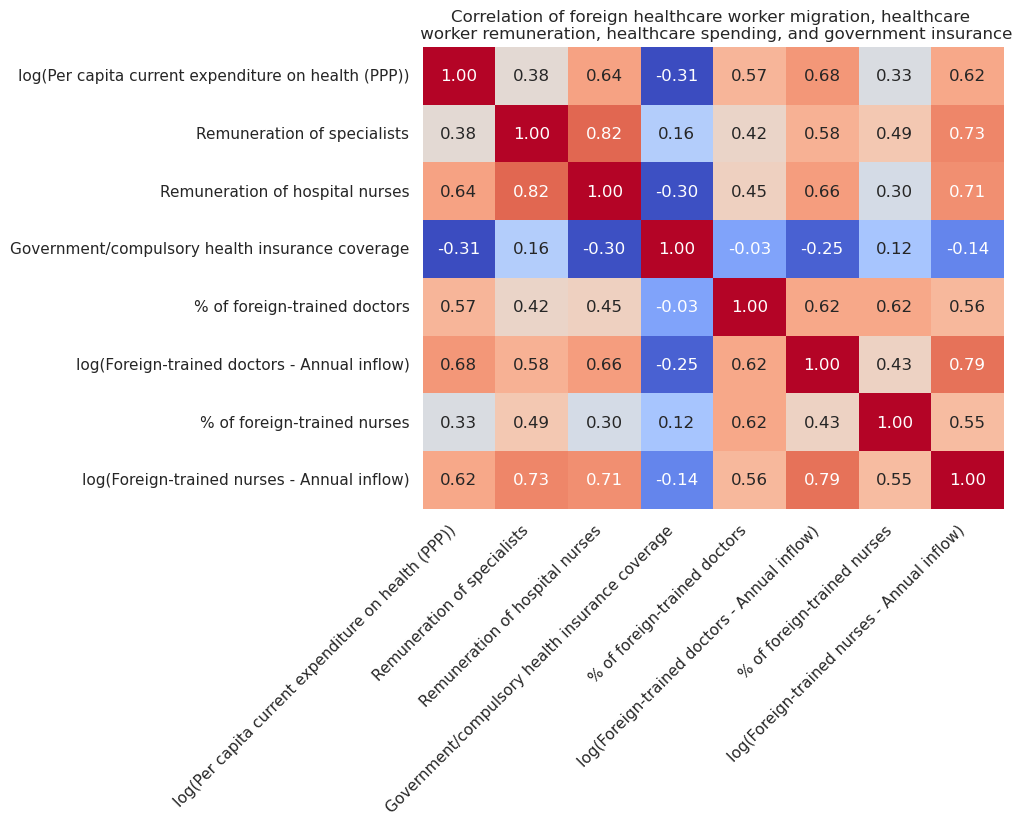

In [25]:
in_hc_rem_corr  = in_hc_rem.corr()

plt.figure(figsize=(7.5, 6))  
sns.heatmap(in_hc_rem_corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=False)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Correlation of foreign healthcare worker migration, healthcare \n worker remuneration, healthcare spending, and government insurance')

plt.show()

All factors are positively correlated with each other, except for government insurance coverage which is negatively correlated with most other factors. The correlations for remuneration of both doctors and nurses are consistent with economic theory, suggesting foreign-trained healthcare workers behave as rational economic agents. 

### Predictive Models

To further predict the behavior of foreign-trained healthcare workers, we generate regressions of migration based on government insurance, healthcare spending, and remuneration.

In [26]:
x_docinf = doc_inf_pred.loc[:,~doc_inf_pred.columns.isin(["log(Foreign-trained doctors - Annual inflow)"])]
y_docinf = doc_inf_pred["log(Foreign-trained doctors - Annual inflow)"]

x_docinf = sm.add_constant(x_docinf)
x_docinf_model = sm.OLS(y_docinf, x_docinf)
x_docinf_result = x_docinf_model.fit()

print(x_docinf_result.summary())

                                         OLS Regression Results                                         
Dep. Variable:     log(Foreign-trained doctors - Annual inflow)   R-squared:                       0.546
Model:                                                      OLS   Adj. R-squared:                  0.474
Method:                                           Least Squares   F-statistic:                     7.609
Date:                                          Tue, 23 Apr 2024   Prob (F-statistic):            0.00154
Time:                                                  00:06:18   Log-Likelihood:                -38.876
No. Observations:                                            23   AIC:                             85.75
Df Residuals:                                                19   BIC:                             90.29
Df Model:                                                     3                                         
Covariance Type:                                      n

**Interpretation**

A 1% increase in per capita health spending gives a 1.95% increase in foreign doctor inflow, a $1000 increase in specialist remuneration gives a 1.92% increase in foreign doctor inflow, and a change in government healthcare coverage is insignificant.

In [27]:
x_docpct = doc_pct_pred.loc[:,~doc_pct_pred.columns.isin(["% of foreign-trained doctors"])]
y_docpct = doc_pct_pred["% of foreign-trained doctors"]

x_docpct = sm.add_constant(x_docpct)
x_docpct_model = sm.OLS(y_docpct, x_docpct)
x_docpct_result = x_docpct_model.fit()

print(x_docpct_result.summary())

                                 OLS Regression Results                                 
Dep. Variable:     % of foreign-trained doctors   R-squared:                       0.373
Model:                                      OLS   Adj. R-squared:                  0.269
Method:                           Least Squares   F-statistic:                     3.570
Date:                          Tue, 23 Apr 2024   Prob (F-statistic):             0.0347
Time:                                  00:06:18   Log-Likelihood:                -86.806
No. Observations:                            22   AIC:                             181.6
Df Residuals:                                18   BIC:                             186.0
Df Model:                                     3                                         
Covariance Type:                      nonrobust                                         
                                                          coef    std err          t      P>|t|      [0.025   

**Interpretation**

A 1% increase in per capita health spending gives a 0.15 percentile point increase in foreign doctor percentage, an increase in specialist remuneration is insignificant, and a change in government healthcare coverage is insignificant.

In [28]:
x_nurinf = nur_inf_pred.loc[:,~nur_inf_pred.columns.isin(["log(Foreign-trained nurses - Annual inflow)"])]
y_nurinf = nur_inf_pred["log(Foreign-trained nurses - Annual inflow)"]

x_nurinf = sm.add_constant(x_nurinf)
x_nurinf_model = sm.OLS(y_nurinf, x_nurinf)
x_nurinf_result = x_nurinf_model.fit()

print(x_nurinf_result.summary())

                                         OLS Regression Results                                        
Dep. Variable:     log(Foreign-trained nurses - Annual inflow)   R-squared:                       0.554
Model:                                                     OLS   Adj. R-squared:                  0.490
Method:                                          Least Squares   F-statistic:                     8.690
Date:                                         Tue, 23 Apr 2024   Prob (F-statistic):           0.000608
Time:                                                 00:06:18   Log-Likelihood:                -47.049
No. Observations:                                           25   AIC:                             102.1
Df Residuals:                                               21   BIC:                             107.0
Df Model:                                                    3                                         
Covariance Type:                                     nonrobust  

**Interpretation**

A 1% increase in per capita health spending gives a 1.29% increase in foreign nurse inflow (marginally significant), a $1000 increase in hospital nurse remuneration gives a 8.27% increase in foreign nurse inflow, and a change in government healthcare coverage is insignificant.

In [29]:
x_nurpct = nur_pct_pred.loc[:,~nur_pct_pred.columns.isin(["% of foreign-trained nurses"])]
y_nurpct = nur_pct_pred["% of foreign-trained nurses"]

x_nurpct = sm.add_constant(x_nurpct)
x_nurpct_model = sm.OLS(y_nurpct, x_nurpct)
x_nurpct_result = x_nurpct_model.fit()

print(x_nurpct_result.summary())

                                 OLS Regression Results                                
Dep. Variable:     % of foreign-trained nurses   R-squared:                       0.175
Model:                                     OLS   Adj. R-squared:                  0.062
Method:                          Least Squares   F-statistic:                     1.552
Date:                         Tue, 23 Apr 2024   Prob (F-statistic):              0.229
Time:                                 00:06:18   Log-Likelihood:                -95.770
No. Observations:                           26   AIC:                             199.5
Df Residuals:                               22   BIC:                             204.6
Df Model:                                    3                                         
Covariance Type:                     nonrobust                                         
                                                          coef    std err          t      P>|t|      [0.025      0.975]


**Interpretation**

No results from this regression are significant. This regression also has a very low adjusted R-squared.

### Results
We find that per capita expenditure on health is significant at the 10% level for the inflow of foreign doctors and the percentage of foreign doctors, and that it is marginally significant (at the 15% level) for the inflow of foreign nurses. It has no significant prediction power for the percentage of foreign trained nurses. This aligns with our expectation that higher healthcare spending is predictive of healthcare worker immigration.

We also find that remuneration of specialists is a significant predictor of foreign doctor inflow but not foreign doctor percentage, and that remuneration of hospital nurses is a significant predictor of foreign nurse inflow but not foreign nurse percentage. This aligns with economic theory; workers flow to higher wages.

Government health care coverage was an insignificant predictor of all factors, which is likely due to the low level of variation in the data.

Three of the four regressions have high adjusted R-square values, suggesting that these predictors collectively explain a significant amount of the variation of all factors except the percentage of foreign trained nurses.

## Relationship Between Domestic and Foreign-Trained Medical Professionals

While we have mentioned the proportions of local and foreign healthcare professionals before, being able to visualize each country's distribution simultaneously provides a reference point about the scale at which foreign-trained healthcare professionals impact their field, i.e. visualizing if foreign-trained healthcare professionals account for 10% of the industry or 40% of the industry may help us observe the scope at which our findings operate.

To do this we use the `worker_migr` dataframe to obtain data suitable for plotting and created `worker_migr_to_plot`, where we calculated and filtered for values regarding the proportion of domestically-trained healthcare workers and the proportion of foreign-trained healthcare workers.

In [30]:
#create new column for percentage of domestically trained healthcare workers
#sum domestic trained doctors and nurses, divide by total
worker_migr['%_of_domestic_trained_healthcare_workers'] = (
    (worker_migr['Domestically-trained doctors'] + worker_migr['Domestically-trained nurses']) /
    (worker_migr['Total number of doctors'] + worker_migr['Total number of nurses'])) * 100

worker_migr['%_of_foreign_trained_healthcare_workers'] = (
    (worker_migr['Foreign-trained doctors - Stock'] + worker_migr['Foreign-trained nurses - Stock']) /
    (worker_migr['Total number of doctors'] + worker_migr['Total number of nurses'])) * 100

worker_migr = worker_migr.reset_index()

In [31]:
worker_migr_to_plot = worker_migr[['Country', 'Year', '%_of_domestic_trained_healthcare_workers',
                                    '%_of_foreign_trained_healthcare_workers']].groupby('Country').mean().dropna().reset_index()

worker_migr_to_plot.head()

Variable,Country,Year,%_of_domestic_trained_healthcare_workers,%_of_foreign_trained_healthcare_workers
0,Australia,2016.5,75.906449,21.387244
1,Austria,2016.0,89.054196,10.917625
2,Belgium,2016.0,94.815600,5.184400
3,Canada,2015.5,88.293546,11.062368
4,Chile,2016.5,89.164194,10.704136


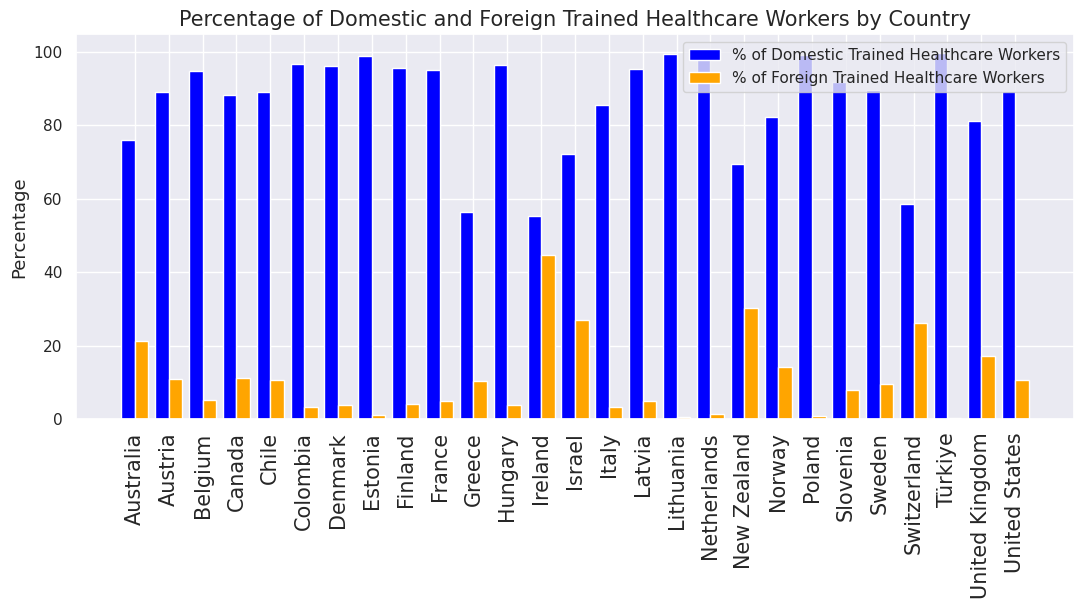

In [32]:
bar_width = 0.4

# bar positions
r1 = np.arange(len(worker_migr_to_plot['Country']))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(11, 6.25))

#domestic healthcare workers
plt.bar(r1, worker_migr_to_plot['%_of_domestic_trained_healthcare_workers'], color='blue', width=bar_width, label='% of Domestic Trained Healthcare Workers')

#foreign healthcare workers
plt.bar(r2, worker_migr_to_plot['%_of_foreign_trained_healthcare_workers'], color='orange', width=bar_width, label='% of Foreign Trained Healthcare Workers')

plt.xticks([r + bar_width/2 for r in range(len(worker_migr_to_plot['Country']))], worker_migr_to_plot['Country'], rotation=90, size = 15)

plt.ylabel('Percentage', size = 13)
plt.title('Percentage of Domestic and Foreign Trained Healthcare Workers by Country', size = 15)
plt.legend()
plt.tight_layout()
plt.show()

As seen in the figure above, most countries' healthcare workforce (doctors and nurses) is predominantly local. However, some interesting patterns emerge. Ireland, Israel, New Zealand, Australia, and Switzerland stand out with over 20% of their healthcare workforce being foreign. While many factors affect these percentages, the OECD's 2015 Health Glance provides some insight; in Israel's case, many licenses are issued to doctors born domestically but who completed their training abroad. Although less prevalent, this pattern is also present in Norway, helping to explain their relatively high percentage of foreign trained health care workers. 

An interesting case study is Switzerland. Several factors appear to influence their healthcare workforce composition. Despite not being in the European Union, there is a free movement of people agreement between Switzerland and the EU. Switzerland's high quality of living and high salaries are likely appealing. This is evidenced by the large majority of these foreign-trained doctors being from neighboring countries, such as France and Italy(OFSP, 2023). Additionally, Switzerland has not trained enough doctors leading to a current shortage of domestically-educated health care professionals.

## Maps

This section contains two interactive maps: one showing total annual inflow of healthcare professionals and the other showing the percentage of foreign healthcare workers. Hover over countries on the maps to see breakdowns by profession.

In [33]:
map_data = worker_migr[['Country', 'Year', '%_of_domestic_trained_healthcare_workers',
                        '%_of_foreign_trained_healthcare_workers', "% of foreign-trained doctors",
                        "% of foreign-trained nurses", "Foreign-trained doctors - Annual inflow",
                        "Foreign-trained nurses - Annual inflow"]].groupby('Country').mean().reset_index()

map_data["Total foreign healthcare professional annual inflow"] = map_data["Foreign-trained doctors - Annual inflow"]+map_data["Foreign-trained nurses - Annual inflow"]
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

world['name'] = world['name'].replace({'United States of America': 'United States', 'Turkey': 'Türkiye'}) 

merged_data = world.merge(map_data, how='left', left_on='name', right_on='Country')

/tmp/ipykernel_7294/1939353147.py:7: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


In [34]:
geo_source = GeoJSONDataSource(geojson=merged_data.to_json())
color_mapper = LinearColorMapper(palette=OrRd[9][::-1], low=0, high=15000)

hover = HoverTool(tooltips=[('Country', '@name'),
                            ('Total foreign healthcare professional annual inflow', '@{Total foreign healthcare professional annual inflow}{0.2f}'),
                            ('Annual inflow of foreign-trained doctors', '@{Foreign-trained doctors - Annual inflow}{0.2f}'),
                            ('Annual inflow of foreign-trained nurses', '@{Foreign-trained nurses - Annual inflow}{0.2f}')])

p = figure(title="Map of OECD Healthcare Immigration (Average Annual Inflow)", align = 'center', tools=[hover], width=1000, height=600)
p.title.align = 'center'
p.patches('xs', 'ys', source=geo_source,
          fill_color={'field': 'Total foreign healthcare professional annual inflow', 'transform': color_mapper},
          line_color='black', line_width=0.5)

color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8, width=500, height=20,
                     border_line_color=None, location='bottom_center', orientation='horizontal', 
                     title="Total foreign healthcare professional annual inflow")

footnote = Label(x=10, y=5, x_units='screen', y_units='screen',
                 text="Source: OECD (2023)", render_mode='css',
                 text_font_size='10pt', text_color='gray')

p.add_layout(footnote)
p.add_layout(color_bar, 'below')

output_notebook()
show(p)

Loading BokehJS ...

In [35]:
geo_source = GeoJSONDataSource(geojson=merged_data.to_json())
color_mapper = LinearColorMapper(palette=OrRd[9][::-1], low=0, high=45)

hover = HoverTool(tooltips=[('Country', '@name'),
                            ('% of foreign-trained healthcare workers', '@{%_of_foreign_trained_healthcare_workers}{0.2f}%'),
                            ('% of foreign-trained doctors', '@{% of foreign-trained doctors}{0.2f}%'),
                            ('% of foreign-trained nurses', '@{% of foreign-trained nurses}{0.2f}%')])

q = figure(title="Map of OECD Healthcare Immigration (% Foreign Trained)", align = 'center', tools=[hover], width=1000, height=600)
q.title.align = 'center'
q.patches('xs', 'ys', source=geo_source,
          fill_color={'field': '%_of_foreign_trained_healthcare_workers', 'transform': color_mapper},
          line_color='black', line_width=0.5)

color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8, width=500, height=20,
                     border_line_color=None, location='bottom_center', orientation='horizontal', 
                     title="% of foreign-trained healthcare workers")

footnote = Label(x=10, y=5, x_units='screen', y_units='screen',
                 text="Source: OECD (2023)", render_mode='css',
                 text_font_size='10pt', text_color='gray')

q.add_layout(footnote)
q.add_layout(color_bar, 'below')

output_notebook()
show(q)

Loading BokehJS ...

The maps succinctly summarize the observations we used as a starting point for this project, as we can visualize the magnitude of the annual inflow of foreign-trained healthcare workers, as well as the proportions of said healthcare workers in OECD countries. It is from here where, due to the differences in values, we thought we could compare the performance of healthcare systems with the inflow and fraction of foreign-trained healthcare workers.

## Conclusion
Throughout this project we explored the relationship among healthcare systems and the migration of healthcare professionals in OECD countries. We started by comparing health quality (through mortality and hospital readmission rates), health status, and patient satisfaction (through percentage of the population with perceived with bad health and proportion of patients with enough consultation time) with annual inflow of foreign healthcare workers. 
The results of this analysis were mixed, as indicated by the significant changes to the coefficient estimates after controlling for the number of domestically-trained doctors. 

Then we explored the behavior of foreign-trained healthcare workers with respect to healthcare spending, remuneration of healthcare workers, and government insurance. The results aligned with economic theory, as greater remuneration and expenditure predicted an increase in the annual inflow and proportion of foreign trained healthcare workers. However, insurance had an insignificant relationship.

Next we displayed the proportions of domestic versus foreign trained healthcare workers, and found that the proportions are predominantly domestic, but there were some countries with considerably higher rates (Israel, Ireland, New Zealand, Australia, and Switzerland).

Lastly, we plotted interactive maps in order to visualize the distribution and magnitude of healthcare professional inflows.

Further research can focus on the impacts of migration on the countries where healthcare professionals emigrated from, and examine if the outcomes in the receiving countries differ based on the distribution of countries of origin of their immigrants. 

## References
Global Affairs Canada. (2017). Global Health and Development. Retrieved from https://www.international.gc.ca/world-monde/issues_development-enjeux_developpement/global_health-sante_mondiale/health_development-sante_developpement.aspx?
lang=eng

OECD (2023), International Migration Outlook 2023, OECD Publishing, Paris, https://doi.org/10.1787/b0f40584-en

OECD (2023), *Demographic References*, OECD.Stat, https://stats.oecd.org/Index.aspx?DataSetCode=HEALTH_DEMR

OECD (2023), *Economic References*, OECD.Stat, https://stats.oecd.org/Index.aspx?DataSetCode=HEALTH_ECOR

OECD (2023), *Health Expenditure and Financing*, OECD.Stat, https://stats.oecd.org/Index.aspx?DataSetCode=SHA

OECD (2015), *International migration of doctors*, in Health at a Glance 2015: OECD Indicators, OECD
Publishing, Paris.

OECD (2023), *Healthcare Quality Indicators*, OECD.Stat, https://stats.oecd.org/Index.aspx?DataSetCode=HEALTH_HCQI

OECD (2023), *Healthcare Resources*, OECD.Stat, https://stats.oecd.org/Index.aspx?DataSetCode=HEALTH_REAC

OECD (2023), *Healthcare Utilization* OECD.Stat, https://stats.oecd.org/Index.aspx?DataSetCode=HEALTH_PROC

OECD (2023), *Social Protection*, OECD.Stat, https://stats.oecd.org/Index.aspx?DataSetCode=HEALTH_PROT

OECD (2023), *Health Workforce Migration*, OECD.Stat, https://stats.oecd.org/Index.aspx?DataSetCode=HEALTH_WFMI

OFSP(2023), *Statistiques médecins*, https://www.bag.admin.ch/bag/fr/home/zahlen-und-statistiken/statistiken-berufe-im-gesundheitswesen/statistiken-medizinalberufe1/statistiken-aerztinnen-aerzte.html
